In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [2]:
import sys
sys.path.insert(1, os.path.join(sys.path[0], '../'))

In [3]:
from copy import deepcopy
from tqdm import tqdm

import torch
from torch import optim
from IPython.display import clear_output

seed = 42
torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from model import DiffusionModel
from training import get_config, ImgDataset, ema_update, demo, generate_img
from diffusion import diffusion_loss

import utils

In [5]:
# Define dataset.
# dataset_name = 'cifar_10'
# dataset_name = 'svhn'
dataset_name = 'fashion_mnist'

save_dir = os.path.join('./output/diffusion_cen', dataset_name)
os.makedirs(save_dir, exist_ok=True)

In [6]:
data_config, train_config = get_config(dataset_name)
print(data_config)
print(train_config)

# Data config.
# img_size = data_config['img_size']
# channels = data_config['channels']
batch_size = data_config['batch_size']
train_transform = data_config['train_transform']
test_transform = data_config['test_transform']

# Training config.
lr = train_config['lr']
timesteps = train_config['timesteps']
num_epochs = train_config['epochs']
ema_decay = train_config['ema_decay']
eta = train_config['eta']
save_interval = train_config['save_interval']

{'img_size': 32, 'channels': 3, 'batch_size': 512, 'train_transform': Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
    Normalize(mean=[0.5], std=[0.5])
), 'test_transform': Compose(
    ToTensor()
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
    Normalize(mean=[0.5], std=[0.5])
)}
{'lr': 0.0002, 'timesteps': 300, 'epochs': 1500, 'rounds': 300, 'local_epochs': 5, 'ema_decay': 0.998, 'eta': 1.0, 'save_interval': 100}


In [7]:
# Data.
data_dir = os.path.join('../datasets/', dataset_name)

train_dir = os.path.join(data_dir, 'train')
train_data = ImgDataset(train_dir, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=12, prefetch_factor=12, pin_memory=True, persistent_workers=True)

test_dir = os.path.join(data_dir, 'test')
test_data = ImgDataset(test_dir, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=12, prefetch_factor=12, pin_memory=True, persistent_workers=True)

In [8]:
# import matplotlib.pyplot as plt
# import torchvision.transforms.functional as F
# import numpy as np

# def show(imgs):
#     if not isinstance(imgs, list):
#         imgs = [imgs]
#     fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
#     for i, img in enumerate(imgs):
#         img = img.detach()
#         img = F.to_pil_image(img)
#         axs[0, i].imshow(np.asarray(img))
#         axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
# img = test_data[1000][0]
# show(img)

In [9]:
# Initialize model.
model = DiffusionModel().to(device)
model_ema = deepcopy(model)
optimizer = optim.Adam(model.parameters(), lr=lr)
grad_scaler = torch.cuda.amp.GradScaler()

In [10]:
# For logging model performance.
metric_keys = ['train_loss', 'test_loss']
performance_dict, performance_log = utils.get_performance_loggers(metric_keys)

In [11]:
# Automatic resuming from checkpoint.
log_path = os.path.join(save_dir, 'performance_log.pickle')
if os.path.isfile(log_path):
    performance_log = utils.load_pickle(log_path)
start_epoch = len(performance_log[metric_keys[0]])

ckpt_path = os.path.join(save_dir, 'ckpt_bundle.pth')
if start_epoch > 0:
    ckpt_bundle = torch.load(ckpt_path)
    model.load_state_dict(ckpt_bundle['model'])
    model_ema.load_state_dict(ckpt_bundle['model_ema'])
    optimizer.load_state_dict(ckpt_bundle['optimizer'])
    grad_scaler.load_state_dict(ckpt_bundle['grad_scaler'])

In [12]:
# Train.
for epoch in range(start_epoch, num_epochs):
    utils.print_separator(text='Epoch: {} / {}'.format(epoch + 1, num_epochs))
    
    # Evaluating.
    model.eval()
    with torch.no_grad():
        with torch.random.fork_rng():
            torch.manual_seed(seed)
            rng = torch.quasirandom.SobolEngine(1, scramble=True)
            for (x, y) in tqdm(test_loader, desc='test'):
                x = x.to(device)
                y = y.to(device)
                
                loss = diffusion_loss(model, x, y)
                performance_dict['test_loss'].update_state(loss.item())
                
    # Training.
    model.train()
    for (x, y) in tqdm(train_loader, desc='train'):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        
        # Calculate loss.
        loss = diffusion_loss(model, x, y)
        performance_dict['train_loss'].update_state(loss.item())
        
        # Do the optimizer step and EMA update.
        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        ema_update(model, model_ema, 0.95 if epoch < 20 else ema_decay)
        grad_scaler.update()
        
    # Save and print performance.
    for key in metric_keys:
        performance_log[key].append(performance_dict[key].result())
        performance_dict[key].reset_state()
        print(key, ': ',  performance_log[key][-1])
        
    if (epoch + 1) % save_interval == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, 'e_{}.pth'.format(str(epoch + 1).zfill(3))))
        img_path = os.path.join(save_dir, 'demo_{}.png'.format(str(epoch + 1).zfill(3)))
        demo(model, img_path, timesteps, eta)
        clear_output(wait=True)
        
    ckpt_bundle = {
        'model': model.state_dict(),
        'model_ema': model_ema.state_dict(),
        'optimizer': optimizer.state_dict(),
        'grad_scaler': grad_scaler.state_dict(),
    }
    torch.save(ckpt_bundle, ckpt_path)
    utils.save_pickle(log_path, performance_log)

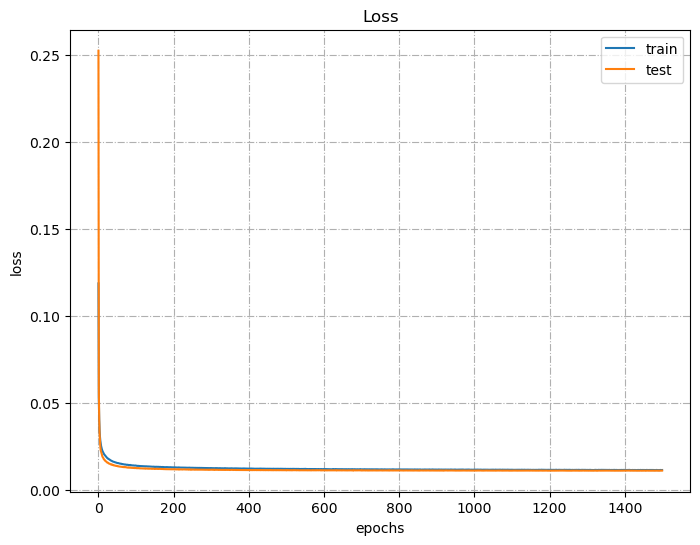

In [13]:
# Plot training history.
performance_log = utils.load_pickle(log_path)

loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['save_dir'] = os.path.join(save_dir, 'loss.png')
loss_plot_config['show_img'] = True
loss_plot_config['xlabel'] = 'epochs'
loss_plot_config['labels'] = ['train', 'test']
loss_plot_config['attributes'] = ['train_loss', 'test_loss']
utils.save_history_plot(performance_log, loss_plot_config)

In [14]:
# Reload saved model for generation.
# model = DiffusionModel().to(device)
# model_ema = deepcopy(model)

# save_bundle = torch.load(os.path.join(save_dir, 'e_{}.pth'.format(str(5).zfill(3))))
# model.load_state_dict(save_bundle['model'])
# model_ema.load_state_dict(save_bundle['model_ema'])

In [15]:
# Reload saved model for generation.
model = DiffusionModel().to(device)
model.load_state_dict(torch.load(os.path.join(save_dir, 'e_{}.pth'.format('1500'.zfill(3)))))

<All keys matched successfully>

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 113.16it/s]


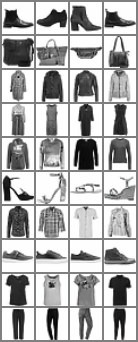

In [16]:
# Generate and save image.
img_path = os.path.join(save_dir, 'demo_final.png')
# demo(model, img_path, timesteps, eta)
demo(model, img_path, timesteps, eta, num_images=4, seed=0)

In [17]:
# Generate and save image.
# img_path = os.path.join(save_dir, 'demo_final.png')
# demo(model_ema, img_path, timesteps, eta)

In [18]:
# Generate images for evaluation.
# idx_label_dict = {v: k for k, v in test_data.label_idx_dict.items()}
# for idx, label in idx_label_dict.items():
#     num_imgs = test_data.label_count_dict[label]
#     img_class = idx
#     class_dir = os.path.join(save_dir, 'generated_img', label)
#     os.makedirs(class_dir, exist_ok=True)
#     generate_img(model, class_dir, timesteps, eta, num_imgs, img_class)

In [19]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")